# Model Training

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import pandas as pd
import os
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import xgboost 
from sklearn.metrics import roc_auc_score
from colorama import Fore
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from dotenv import load_dotenv

# Loading Data

In [2]:
load_dotenv()

secure_bundle = os.getenv('secure_bundle')
client_id = os.getenv('client_id')
client_secret = os.getenv('client_secret')

cloud_config= {
        'secure_connect_bundle': secure_bundle  
}

auth_provider = PlainTextAuthProvider(client_id, client_secret)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

train_df = pd.DataFrame(list(session.execute('SELECT * FROM stroke.data;')))
train_df.drop(columns=["id"],inplace=True)
train_df.tail(1)

,calc,cond,gravity,osmo,ph,target,urea
413,3.16,25.7,1.021,442,5.53,0,398


# Feature Engineering

`1.Relative saturation` of calcium oxalate: This feature could be calculated using the concentration of calcium and the pH of urine, which can provide information about the relative saturation of calcium oxalate, a common type of kidney stone. This feature could help predict the risk of calcium oxalate stone formation.

`2.Ionic strength` of urine: This feature could be calculated using the osmolarity and conductivity of urine, which can provide information about the concentration of ions in the urine. This feature could help predict the risk of stone formation, as high ionic strength can promote the aggregation of stone-forming crystals.

`3.Dehydration index:` This feature could be calculated using the specific gravity and urea concentration of urine, which can provide information about the hydration status of the individual. This feature could help predict the risk of stone formation, as dehydration can increase the concentration of stone-forming substances in the urine.

`4.Calcium-creatinine ratio:` This feature could be calculated using the concentration of calcium and creatinine in urine, which can provide information about the excretion of calcium in relation to the overall kidney function. This feature could help identify individuals at risk of stone formation due to excessive calcium excretion.

`5.Urea-pH interaction:` This feature could be calculated by examining the relationship between urea concentration and urine pH. This feature could provide information about the acid-base balance of the urine and help identify individuals at risk of stone formation due to changes in urine pH.

In [3]:
# from https://www.kaggle.com/code/tetsutani/ps3e12-eda-ensemble-baseline?scriptVersionId=124746389&cellId=11

def create_new_features(data):
    # Ion product of calcium and urea
    data["ion_product"] = data["calc"] * data["urea"]

    # Calcium-to-urea ratio
    data["calcium_to_urea_ratio"] = data["calc"] / data["urea"]

    # Electrolyte balance
    data["electrolyte_balance"] = data["cond"] / (10 ** (-data["ph"]))

    # Osmolality-to-specific gravity ratio
    data["osmolality_to_sg_ratio"] = data["osmo"] / data["gravity"]
    
    ## Add Feature engineering part 
    # The product of osmolarity and density is created as a new property
    data['osmo_density'] = data['osmo'] * data['gravity']

        # Converting pH column to categorical variable
    data['pH_cat'] = pd.cut(data['ph'], bins=[0, 4.5, 6.5, 8.5, 14], labels=['sangat acidic', 'acidic', 'neutral', 'basic'])
    dummies = pd.get_dummies(data['pH_cat'])
    data = pd.concat([data, dummies], axis=1)
    
    # Deleting columns using dummy variables.
    data.drop(['pH_cat', 'sangat acidic' , 'basic','neutral','ph'], axis=1, inplace=True)
    
    return data

# Model Training

In [4]:
tr = train_df.copy()
data = tr.drop(columns=['target'])
target = tr['target']

In [5]:
data = create_new_features(data)

In [6]:
data

,calc,cond,gravity,osmo,urea,ion_product,calcium_to_urea_ratio,electrolyte_balance,osmolality_to_sg_ratio,osmo_density,acidic
0,1.53,23.6,1.007,704,260,397.80,0.005884615384615384615384615385,17494921.69470165335195601379,699.1062562065541211519364449,708.928,1
1,0.65,10.9,1.007,242,14,9.10,0.04642857142857142857142857143,82684955.67818103079416057541,240.3177755710029791459781529,243.694,0
2,7.82,29.5,1.024,866,360,2815.20,0.02172222222222222222222222222,11744161.53132816889772244300,845.703125,886.784,1
3,4.49,20.0,1.025,442,398,1787.02,0.01128140703517587939698492462,37241742.73325734897343557995,431.2195121951219512195121951,453.050,1
4,2.17,8.1,1.017,527,170,368.90,0.01276470588235294117647058824,3079534.110196545688812620460,518.1907571288102261553588987,535.959,1
...,...,...,...,...,...,...,...,...,...,...,...
409,4.49,29.0,1.025,876,308,1382.92,0.01457792207792207792207792208,13880272.67735651197374054444,854.6341463414634146341463415,897.900,1
410,3.16,20.9,1.034,577,161,508.76,0.01962732919254658385093167702,7945958.383099728999528860200,558.0270793036750483558994197,596.618,1
411,8.48,15.6,1.019,775,302,2560.96,0.02807947019867549668874172185,3918542.833154944973292650026,760.5495583905789990186457311,789.725,1
412,1.03,8.8,1.008,242,64,65.92,0.01609375,16768054.31807657520765452482,240.0793650793650793650793651,243.936,1


In [7]:
data_pipline = Pipeline([
    ('scaler',StandardScaler())
])

X = data
Y = target

split = StratifiedKFold(random_state=42,shuffle=True)
Fold=0

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf_train_score = []
rf_val_score = []
rf_model_list = []
Fold= 0
for train_index, eval_index in (split.split(X,Y)):
    Fold = Fold+1
    x_train, y_train = X.iloc[train_index], Y.iloc[train_index]
    x_eval, y_eval = X.iloc[eval_index], Y.iloc[eval_index]

    model = RandomForestClassifier()
    X_train_prepared = data_pipline.fit_transform(x_train)
    X_eval_prepared = data_pipline.fit_transform(x_eval)

    print(f'Fold :{Fold}')
    model.fit(X_train_prepared, y_train)
    train_pred = roc_auc_score(y_train, model.predict_proba(X_train_prepared)[:,1])
    eval_pred = roc_auc_score(y_eval, model.predict_proba(X_eval_prepared)[:,1])

    rf_train_score.append(train_pred)
    rf_val_score.append(eval_pred)
    rf_model_list.append([data_pipline,model])
    print(f'{Fore.BLACK} Val roc AUC score: {Fore.BLUE} {eval_pred}')

print()
print(f'{Fore.BLACK} Mean Val roc scores : {Fore.GREEN}{np.mean(rf_val_score)}')

Fold :1
 Val roc AUC score:  0.6883078730904818
Fold :2
 Val roc AUC score:  0.7364864864864866
Fold :3
 Val roc AUC score:  0.7270857814336075
Fold :4
 Val roc AUC score:  0.8022914218566392
Fold :5
 Val roc AUC score:  0.8019323671497585

 Mean Val roc scores : 0.7512207860033947


In [9]:
model.feature_importances_

array([0.18575449, 0.08729852, 0.05907177, 0.0514654 , 0.07033751,
       0.15423632, 0.12849926, 0.11329613, 0.06787209, 0.07393986,
       0.00822865])

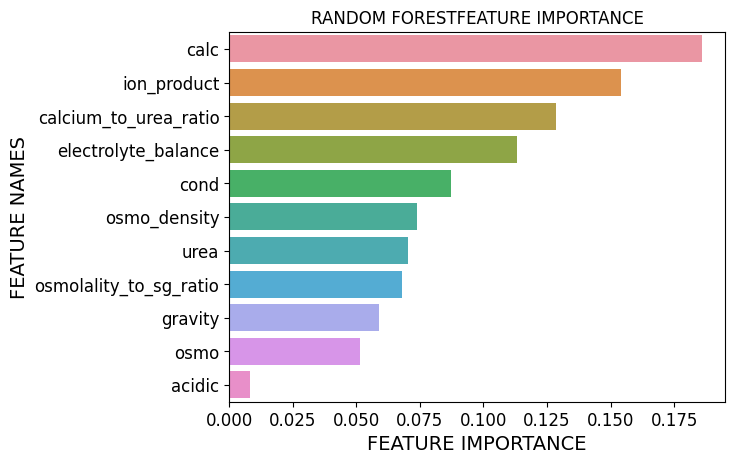

In [10]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    # plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    # Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

plot_feature_importance(model.feature_importances_,data.columns,'RANDOM FOREST')